In [3]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import os

# Doubt: NN may have bad landscapes. BFGS may perform worse than Adam at high loss.

np.random.seed(1)
torch.manual_seed(1)

# Define Transformer


# (t,rho,z) -> (t',rho',z')
class T(nn.Module):
    def __init__(self,w=256,a=0.,M=1.):
        super(T, self).__init__()
        self.l1 = nn.Linear(2,w)
        self.l2 = nn.Linear(w,w)
        self.l3 = nn.Linear(w,4)
        self.a = a
        self.M = torch.nn.Parameter(torch.ones(1,)*1., requires_grad=False)
        self.eps = torch.nn.Parameter(torch.ones(1,)*0.01, requires_grad=False)
    
    def forward(self, x):
        bs = x.shape[0]
        # These non-polynomial activation function may not lead to power laws
        #f = nn.Tanh()
        #f = nn.SiLU()
        #f = Rational()
        f = nn.ReLU()
        self.t = x[:,[0]]
        self.x = x[:,[1]]
        self.y = x[:,[2]]
        self.z = x[:,[3]]
        self.r = torch.sqrt(self.x**2+self.y**2+self.z**2)
        self.u = torch.sqrt(self.r/(2*self.M))

        self.rho = torch.unsqueeze(torch.sqrt(x[:,1]**2+x[:,2]**2),dim=1)
        self.rhoz = torch.transpose(torch.stack([self.rho,self.z]),0,1)[:,:,0]
        
        self.x1 = f(self.l1(self.rhoz))
        self.x2 = f(self.l2(self.x1))**2
        self.x3 = self.l3(self.x2)

        self.dt = self.x3[:,[0]]
        self.drho = self.x3[:,[1]]
        self.dphi = self.x3[:,[2]]
        self.dz = self.x3[:,[3]]
        nn_out = torch.empty((x.shape[0], 4), requires_grad=False)
        nn_out[:,[0]] = self.dt
        nn_out[:,[1]] = (-self.y*self.dphi+self.x*self.drho)
        nn_out[:,[2]] = (self.x*self.dphi+self.y*self.drho)
        nn_out[:,[3]] = self.dz*self.z

        return x + self.eps.unsqueeze(dim=0)*nn_out
    
    def set_a(self,a):
        self.a = a
        
    def batch_jacobian(self, func, x, create_graph=False):
        # x in shape (Batch, Length)
        def _func_sum(x):
            return func(x).sum(dim=0)
        return torch.autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)
    
    def transform_g(self, x):
        jac_ts = self.batch_jacobian(self.forward, x, create_graph=True)
        jac_inv_ts = torch.inverse(jac_ts)
        return torch.matmul(torch.matmul(jac_inv_ts.permute(0,2,1), g(x)),jac_inv_ts)
        
    def jac(self, x):
        jac_ts = self.batch_jacobian(self.forward, x, create_graph=True)
        return jac_ts
    

def grow(t1, t2, w_s, w_l):

    w_mask = torch.zeros(w_l,w_l)
    w_mask[:w_s,:w_s] = torch.ones(w_s,w_s)

    b_mask = torch.zeros(w_l,)
    b_mask[:w_s] = torch.ones(w_s,)

    t2.l2.weight.data = t2.l2.weight.data*w_mask
    t2.l2.weight.data[:w_s,:w_s] = t1.l2.weight.data
    t2.l2.bias.data = t2.l2.bias.data*b_mask
    t2.l2.bias.data[:w_s] = t1.l2.bias.data

    t2.l1.weight.data[:w_s,:] = t1.l1.weight.data
    t2.l1.bias.data[:w_s] = t1.l1.bias.data

    t2.l3.weight.data[:,:w_s] = t1.l3.weight.data
    t2.l3.bias.data = t1.l3.bias.data
    return t2
    

In [4]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

n_train = 1000

W = torch.normal(0,1,size=(n_train,4),requires_grad=True)
input_ = torch.empty(n_train,4, requires_grad=False)
input_[:,0] = (torch.rand(n_train, requires_grad=True)-0.5)*3.0 + 1.5
rs = torch.linspace(3,4,steps=n_train+1)[:n_train]
input_[:,1:] = W[:,1:]/torch.norm(W[:,1:], dim=1, keepdim=True)*torch.unsqueeze(rs, dim=1)

n_test = 1000

W_test = torch.normal(0,1,size=(n_test,4),requires_grad=True)
input_test_ = torch.empty(n_test,4, requires_grad=False)
input_test_[:,0] = (torch.rand(n_test, requires_grad=True)-0.5)*3.0 + 1.5
rs_test = torch.linspace(3,4,steps=n_test+1)[:n_test]
input_test_[:,1:] = W_test[:,1:]/torch.norm(W_test[:,1:], dim=1, keepdim=True)*torch.unsqueeze(rs_test, dim=1)



In [10]:
import copy
import time

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

# w/wo growing network
# Tanh, Relu, Relu2 activation, last-layer act(other relu). Even: Should we use spline networks?
# Hybrid: Adam + LBFGS
# Possible overfitting: train & test gap
# LBFGS usage

#ws = [50,60,70,80,90,100,120,140,160,180,200,250,300,350,400]
ws = [5,10,15,20,25,30,35,40,45,50]
#ws = [14]
#ws = [2,4]
losses_w = []
losses_w_test = []
times = []

a_s = [0.0]

w_i = 0

for w in ws:
    
    print("w={}".format(w))
    if w_i == 0:
        t = T(w=w, a=0.0, M=1.0)
    else:
        sd = t.state_dict()
        t_old = T(w=w_old, a=0.0, M=1.0)
        t_old.load_state_dict(sd)
        t = T(w=w, a=0.0, M=1.0)
        t = grow(t_old, t, w_old, w)
    w_i = w_i + 1


    losses_a = []
    losses_all = []
    a_i = 0



    for a_kerr in a_s:
        M = 1.0
        r_c = M + np.sqrt(M**2-a_kerr**2)
        print("a_kerr={}".format(a_kerr))
        print("M={}".format(M))
        print("r_c={}".format(r_c))
        #t = T(w=400, a=a_kerr, M=M)
        t.set_a(a_kerr)
        a_i += 1


        # Kerr Metric
        def g(x_):
            a = a_kerr
            bs = x_.shape[0]
            t = x_[:,0]
            x = x_[:,1]
            y = x_[:,2]
            z = x_[:,3]
            rho = torch.sqrt(x**2+y**2)
            r = torch.sqrt(x**2+y**2+z**2)
            costheta = z/r
            sintheta = rho/r
            sin2theta = 2*sintheta*costheta
            cos2theta = 2*costheta**2 - 1
            cosphi = x/rho
            sinphi = y/rho
            sigma = r**2 + a**2*costheta**2
            zeta = torch.sqrt(r**2+a**2)
            sq2 = torch.sqrt(torch.tensor(2., dtype=torch.float, requires_grad=False))

            u1 = a**2 + 2*r**2 + a**2*cos2theta
            zeta = torch.sqrt(a**2+r**2)
            u2 = u1/(zeta*torch.sqrt(M*r))
            u3 = 8*a*M/sigma
            u4 = zeta**2 + 2*a**2*M*r*sintheta**2/sigma

            g00 = -1 + 2*M*r/sigma
            g01 = g10 = 1/4*sintheta*(sq2*u2*cosphi+u3*sinphi)
            g02 = g20 = 1/4*sintheta*(-u3*cosphi+sq2*u2*sinphi)
            g03 = g30 = costheta*u2/sq2**3
            g11 = (8*costheta**2*cosphi**2*sigma-u2**2*r**2*cosphi**2*sintheta**2+8*u4*sinphi**2)/(8*r**2)
            g12 = g21 = cosphi*(8*costheta**2*sigma-u2**2*r**2*sintheta**2-8*u4)*sinphi/(8*r**2)
            g13 = g31 = costheta*(-8*sigma-u2**2*r**2)*cosphi*sintheta/(8*r**2)
            g22 = (8*cosphi**2*u4+8*costheta**2*sigma*sinphi**2-u2**2*r**2*sintheta**2*sinphi**2)/(8*r**2)
            g23 = g32 = costheta*(-8*sigma-u2**2*r**2)*sintheta*sinphi/(8*r**2)
            g33 = sintheta**2 + costheta**2*(-u2**2*r**2+8*a**2*sintheta**2)/(8*r**2)

            stack1 = torch.stack([g00, g01, g02, g03])
            stack2 = torch.stack([g10, g11, g12, g13])
            stack3 = torch.stack([g20, g21, g22, g23])
            stack4 = torch.stack([g30, g31, g32, g33])

            gs = - torch.stack([stack1, stack2, stack3, stack4]).permute(2,0,1)
            return gs
        
        def euclidean_loss(t,inputs):
            gp = t.transform_g(inputs)
            bs = gp.shape[0]
            minkowski_metric = torch.unsqueeze(torch.unsqueeze(torch.ones(bs,),dim=1),dim=2) * torch.unsqueeze(torch.diag(torch.tensor([-1.,-1.,-1.], dtype=torch.float, requires_grad=True)), dim=0)
            return torch.mean((gp[:,1:,1:]-minkowski_metric)**2)



        lr = 0.1*(5/w)**2
        '''if w_i == 0:
            epochs = 2500
            BFGS_epoch = 2000
        else:
            epochs = 500
            BFGS_epoch = 0'''
        
        # We need to understand LBFGS better
        epochs = 300
        switch_epoch = 100
        BFGS_epoch = 1000000

        #optimizer = optim.Adam(t.parameters(), lr=lr, eps=1e-8)
        #optimizer = optim.SGD(t.parameters(),lr=lr)
        optimizer = optim.LBFGS(t.parameters(), lr=lr, max_iter=100, max_eval=None, tolerance_grad=1e-30, tolerance_change=1e-30, history_size=100, line_search_fn='strong_wolfe')
        #optimizer = optim.LBFGS(t.parameters(), lr=0.1, max_iter=100, max_eval=1e10, tolerance_grad=1e-30, tolerance_change=1e-30, history_size=100)



        #epochs = 100
        #optimizer = optim.LBFGS(t.parameters(), lr=1, max_iter=100, max_eval=None, tolerance_grad=1e-30, tolerance_change=1e-30, history_size=100, line_search_fn="strong_wolfe")
        #optimizer = optim.LBFGS(t.parameters(), lr=1, max_iter=20, max_eval=None, tolerance_grad=1e-07, tolerance_change=1e-09, history_size=100, line_search_fn=None)

        log_save = 100000

        losses = []

        n_train = 1000
        
        best_loss = 10000
        
        start = time.time()

        for epoch in range(epochs):

            if (epoch+1) % switch_epoch == 0:
                for opt_param in optimizer.param_groups:
                    lr = lr * 0.5
                    opt_param['lr'] = lr

            if epoch == BFGS_epoch:
                # BFGS learning rate. How to set?
                optimizer = optim.LBFGS(t.parameters(), lr=0.1, max_iter=100, max_eval=1e10, tolerance_grad=1e-30, tolerance_change=1e-30, history_size=100, line_search_fn='strong_wolfe')

            if epoch < BFGS_epoch:
                log = 1
                batch_size = n_train
            else:
                log = 1
                batch_size = n_train
            t.train()


            choices = np.random.choice(n_train, batch_size, replace=False)
            inputs = input_[choices]

            # -------------------------------------------
            def loss_closure():
                if torch.is_grad_enabled():
                    optimizer.zero_grad()
                loss_inner = euclidean_loss(t,inputs)
                #if loss_inner.requires_grad:
                    #loss_inner.backward(retain_graph=True)
                    #loss_inner.backward()
                loss_inner.backward(retain_graph=True)
                return loss_inner
            # -------------------------------------------
            loss = loss_closure()
            # best_loss is trick for better scaling laws
            if loss < best_loss:
                best_loss = loss
                best_epoch = epoch
                def loss_closure_test():
                    if torch.is_grad_enabled():
                        optimizer.zero_grad()
                    loss_inner = euclidean_loss(t,input_test_)
                    return loss_inner
                loss_test = loss_closure_test()
            optimizer.step(loss_closure)  # get loss, use to update wts

            losses.append(loss.detach().numpy())
            losses_all.append(loss.detach().numpy())
            '''loss = euclidean_loss(g,t,inputs)
            loss.backward()
            optimizer.step()'''
            

            if epoch%log == 0:
                print('Epoch:  %d | loss: %.12f ' %(epoch, loss))

    end = time.time()
    duration = end - start
    print("time={}".format(duration))
    times.append(duration)


                
    w_old = w
    losses_w.append(best_loss.detach().numpy())
    losses_w_test.append(loss_test.detach().numpy())
    print("best_train_loss={}".format(best_loss.detach().numpy()))
    print("test_loss={}".format(loss_test.detach().numpy()))
    print("best_epoch={}".format(best_epoch))
    
np.save('./results_nn/grow_relu2last_bfgs_lrdecay',np.array([ws, losses_w, times, losses_w_test]))


w=5
a_kerr=0.0
M=1.0
r_c=2.0
Epoch:  0 | loss: 0.840038895607 
Epoch:  1 | loss: 0.030007967725 
Epoch:  2 | loss: 0.027235690504 
Epoch:  3 | loss: 0.027235690504 
Epoch:  4 | loss: 0.027235692367 
Epoch:  5 | loss: 0.027235694230 
Epoch:  6 | loss: 0.027235692367 
Epoch:  7 | loss: 0.027235692367 
Epoch:  8 | loss: 0.027235688642 
Epoch:  9 | loss: 0.027235690504 
Epoch:  10 | loss: 0.027235690504 
Epoch:  11 | loss: 0.027235692367 
Epoch:  12 | loss: 0.027235692367 
Epoch:  13 | loss: 0.027235690504 
Epoch:  14 | loss: 0.027235694230 
Epoch:  15 | loss: 0.027235694230 
Epoch:  16 | loss: 0.027235692367 
Epoch:  17 | loss: 0.027235692367 
Epoch:  18 | loss: 0.027235694230 
Epoch:  19 | loss: 0.027235694230 
Epoch:  20 | loss: 0.027235692367 
Epoch:  21 | loss: 0.027235692367 
Epoch:  22 | loss: 0.027235690504 
Epoch:  23 | loss: 0.027235694230 
Epoch:  24 | loss: 0.027235690504 
Epoch:  25 | loss: 0.027235694230 
Epoch:  26 | loss: 0.027235692367 
Epoch:  27 | loss: 0.027235690504 
E

Epoch:  231 | loss: 0.027235692367 
Epoch:  232 | loss: 0.027235692367 
Epoch:  233 | loss: 0.027235690504 
Epoch:  234 | loss: 0.027235692367 
Epoch:  235 | loss: 0.027235690504 
Epoch:  236 | loss: 0.027235690504 
Epoch:  237 | loss: 0.027235690504 
Epoch:  238 | loss: 0.027235690504 
Epoch:  239 | loss: 0.027235694230 
Epoch:  240 | loss: 0.027235692367 
Epoch:  241 | loss: 0.027235690504 
Epoch:  242 | loss: 0.027235692367 
Epoch:  243 | loss: 0.027235694230 
Epoch:  244 | loss: 0.027235692367 
Epoch:  245 | loss: 0.027235690504 
Epoch:  246 | loss: 0.027235692367 
Epoch:  247 | loss: 0.027235690504 
Epoch:  248 | loss: 0.027235692367 
Epoch:  249 | loss: 0.027235692367 
Epoch:  250 | loss: 0.027235690504 
Epoch:  251 | loss: 0.027235692367 
Epoch:  252 | loss: 0.027235690504 
Epoch:  253 | loss: 0.027235692367 
Epoch:  254 | loss: 0.027235692367 
Epoch:  255 | loss: 0.027235688642 
Epoch:  256 | loss: 0.027235690504 
Epoch:  257 | loss: 0.027235692367 
Epoch:  258 | loss: 0.027235

Epoch:  158 | loss: 0.027233995497 
Epoch:  159 | loss: 0.027233924717 
Epoch:  160 | loss: 0.027233920991 
Epoch:  161 | loss: 0.027233907953 
Epoch:  162 | loss: 0.027233893052 
Epoch:  163 | loss: 0.027233870700 
Epoch:  164 | loss: 0.027233863249 
Epoch:  165 | loss: 0.027233863249 
Epoch:  166 | loss: 0.027233865112 
Epoch:  167 | loss: 0.027233814821 
Epoch:  168 | loss: 0.027233783156 
Epoch:  169 | loss: 0.027233758941 
Epoch:  170 | loss: 0.027233729139 
Epoch:  171 | loss: 0.027233695611 
Epoch:  172 | loss: 0.027233686298 
Epoch:  173 | loss: 0.027233673260 
Epoch:  174 | loss: 0.027233665809 
Epoch:  175 | loss: 0.027233645320 
Epoch:  176 | loss: 0.027233626693 
Epoch:  177 | loss: 0.027233611792 
Epoch:  178 | loss: 0.027233613655 
Epoch:  179 | loss: 0.027233608067 
Epoch:  180 | loss: 0.027233606204 
Epoch:  181 | loss: 0.027233585715 
Epoch:  182 | loss: 0.027233585715 
Epoch:  183 | loss: 0.027233550325 
Epoch:  184 | loss: 0.027233524248 
Epoch:  185 | loss: 0.027233

Epoch:  85 | loss: 0.027205090970 
Epoch:  86 | loss: 0.027204900980 
Epoch:  87 | loss: 0.027204714715 
Epoch:  88 | loss: 0.027204528451 
Epoch:  89 | loss: 0.027204345912 
Epoch:  90 | loss: 0.027204180136 
Epoch:  91 | loss: 0.027203999460 
Epoch:  92 | loss: 0.027203921229 
Epoch:  93 | loss: 0.027203744277 
Epoch:  94 | loss: 0.027203565463 
Epoch:  95 | loss: 0.027203390375 
Epoch:  96 | loss: 0.027203226462 
Epoch:  97 | loss: 0.027203163132 
Epoch:  98 | loss: 0.027202993631 
Epoch:  99 | loss: 0.027202824131 
Epoch:  100 | loss: 0.027202822268 
Epoch:  101 | loss: 0.027202822268 
Epoch:  102 | loss: 0.027202824131 
Epoch:  103 | loss: 0.027202812955 
Epoch:  104 | loss: 0.027202812955 
Epoch:  105 | loss: 0.027202814817 
Epoch:  106 | loss: 0.027202805504 
Epoch:  107 | loss: 0.027202809229 
Epoch:  108 | loss: 0.027202805504 
Epoch:  109 | loss: 0.027202803642 
Epoch:  110 | loss: 0.027202803642 
Epoch:  111 | loss: 0.027202801779 
Epoch:  112 | loss: 0.027202801779 
Epoch: 

Epoch:  11 | loss: 0.027200851589 
Epoch:  12 | loss: 0.027200840414 
Epoch:  13 | loss: 0.027200840414 
Epoch:  14 | loss: 0.027200840414 
Epoch:  15 | loss: 0.027200818062 
Epoch:  16 | loss: 0.027200805023 
Epoch:  17 | loss: 0.027200803161 
Epoch:  18 | loss: 0.027200780809 
Epoch:  19 | loss: 0.027200782672 
Epoch:  20 | loss: 0.027200730518 
Epoch:  21 | loss: 0.027200726792 
Epoch:  22 | loss: 0.027200726792 
Epoch:  23 | loss: 0.027200728655 
Epoch:  24 | loss: 0.027200685814 
Epoch:  25 | loss: 0.027200687677 
Epoch:  26 | loss: 0.027200674638 
Epoch:  27 | loss: 0.027200669050 
Epoch:  28 | loss: 0.027200669050 
Epoch:  29 | loss: 0.027200670913 
Epoch:  30 | loss: 0.027200652286 
Epoch:  31 | loss: 0.027200652286 
Epoch:  32 | loss: 0.027200646698 
Epoch:  33 | loss: 0.027200646698 
Epoch:  34 | loss: 0.027200639248 
Epoch:  35 | loss: 0.027200631797 
Epoch:  36 | loss: 0.027200613171 
Epoch:  37 | loss: 0.027200596407 
Epoch:  38 | loss: 0.027200583369 
Epoch:  39 | loss: 0

Epoch:  242 | loss: 0.027186891064 
Epoch:  243 | loss: 0.027186889201 
Epoch:  244 | loss: 0.027186885476 
Epoch:  245 | loss: 0.027186885476 
Epoch:  246 | loss: 0.027186889201 
Epoch:  247 | loss: 0.027186887339 
Epoch:  248 | loss: 0.027186887339 
Epoch:  249 | loss: 0.027186885476 
Epoch:  250 | loss: 0.027186885476 
Epoch:  251 | loss: 0.027186885476 
Epoch:  252 | loss: 0.027186879888 
Epoch:  253 | loss: 0.027186881751 
Epoch:  254 | loss: 0.027186883613 
Epoch:  255 | loss: 0.027186870575 
Epoch:  256 | loss: 0.027186868712 
Epoch:  257 | loss: 0.027186872438 
Epoch:  258 | loss: 0.027186868712 
Epoch:  259 | loss: 0.027186870575 
Epoch:  260 | loss: 0.027186866850 
Epoch:  261 | loss: 0.027186864987 
Epoch:  262 | loss: 0.027186868712 
Epoch:  263 | loss: 0.027186864987 
Epoch:  264 | loss: 0.027186866850 
Epoch:  265 | loss: 0.027186864987 
Epoch:  266 | loss: 0.027186864987 
Epoch:  267 | loss: 0.027186863124 
Epoch:  268 | loss: 0.027186864987 
Epoch:  269 | loss: 0.027186

Epoch:  169 | loss: 0.027185937390 
Epoch:  170 | loss: 0.027185924351 
Epoch:  171 | loss: 0.027185922489 
Epoch:  172 | loss: 0.027185903862 
Epoch:  173 | loss: 0.027185885236 
Epoch:  174 | loss: 0.027185883373 
Epoch:  175 | loss: 0.027185885236 
Epoch:  176 | loss: 0.027185883373 
Epoch:  177 | loss: 0.027185849845 
Epoch:  178 | loss: 0.027185851708 
Epoch:  179 | loss: 0.027185842395 
Epoch:  180 | loss: 0.027185834944 
Epoch:  181 | loss: 0.027185823768 
Epoch:  182 | loss: 0.027185797691 
Epoch:  183 | loss: 0.027185792103 
Epoch:  184 | loss: 0.027185739949 
Epoch:  185 | loss: 0.027185717598 
Epoch:  186 | loss: 0.027185693383 
Epoch:  187 | loss: 0.027185687795 
Epoch:  188 | loss: 0.027185680345 
Epoch:  189 | loss: 0.027185676619 
Epoch:  190 | loss: 0.027185678482 
Epoch:  191 | loss: 0.027185648680 
Epoch:  192 | loss: 0.027185643092 
Epoch:  193 | loss: 0.027185641229 
Epoch:  194 | loss: 0.027185637504 
Epoch:  195 | loss: 0.027185631916 
Epoch:  196 | loss: 0.027185

Epoch:  96 | loss: 0.027169866487 
Epoch:  97 | loss: 0.027169683948 
Epoch:  98 | loss: 0.027169624344 
Epoch:  99 | loss: 0.027169451118 
Epoch:  100 | loss: 0.027169441804 
Epoch:  101 | loss: 0.027169439942 
Epoch:  102 | loss: 0.027169439942 
Epoch:  103 | loss: 0.027169438079 
Epoch:  104 | loss: 0.027169438079 
Epoch:  105 | loss: 0.027169436216 
Epoch:  106 | loss: 0.027169436216 
Epoch:  107 | loss: 0.027169436216 
Epoch:  108 | loss: 0.027169436216 
Epoch:  109 | loss: 0.027169436216 
Epoch:  110 | loss: 0.027169436216 
Epoch:  111 | loss: 0.027169436216 
Epoch:  112 | loss: 0.027169436216 
Epoch:  113 | loss: 0.027169434354 
Epoch:  114 | loss: 0.027169426903 
Epoch:  115 | loss: 0.027169428766 
Epoch:  116 | loss: 0.027169428766 
Epoch:  117 | loss: 0.027169426903 
Epoch:  118 | loss: 0.027169426903 
Epoch:  119 | loss: 0.027169423178 
Epoch:  120 | loss: 0.027169423178 
Epoch:  121 | loss: 0.027169423178 
Epoch:  122 | loss: 0.027169423178 
Epoch:  123 | loss: 0.0271694213

Epoch:  21 | loss: 0.027167212218 
Epoch:  22 | loss: 0.027167188004 
Epoch:  23 | loss: 0.027167139575 
Epoch:  24 | loss: 0.027167003602 
Epoch:  25 | loss: 0.027166860178 
Epoch:  26 | loss: 0.027166720480 
Epoch:  27 | loss: 0.027166722342 
Epoch:  28 | loss: 0.027166586369 
Epoch:  29 | loss: 0.027166491374 
Epoch:  30 | loss: 0.027166433632 
Epoch:  31 | loss: 0.027166413143 
Epoch:  32 | loss: 0.027166280895 
Epoch:  33 | loss: 0.027166144922 
Epoch:  34 | loss: 0.027166098356 
Epoch:  35 | loss: 0.027165964246 
Epoch:  36 | loss: 0.027165943757 
Epoch:  37 | loss: 0.027165800333 
Epoch:  38 | loss: 0.027165664360 
Epoch:  39 | loss: 0.027165630832 
Epoch:  40 | loss: 0.027165487409 
Epoch:  41 | loss: 0.027165453881 
Epoch:  42 | loss: 0.027165316045 
Epoch:  43 | loss: 0.027165178210 
Epoch:  44 | loss: 0.027165049687 
Epoch:  45 | loss: 0.027164911851 
Epoch:  46 | loss: 0.027164869010 
Epoch:  47 | loss: 0.027164813131 
Epoch:  48 | loss: 0.027164740488 
Epoch:  49 | loss: 0

Epoch:  253 | loss: 0.027159936726 
Epoch:  254 | loss: 0.027159933001 
Epoch:  255 | loss: 0.027159934863 
Epoch:  256 | loss: 0.027159934863 
Epoch:  257 | loss: 0.027159933001 
Epoch:  258 | loss: 0.027159934863 
Epoch:  259 | loss: 0.027159934863 
Epoch:  260 | loss: 0.027159933001 
Epoch:  261 | loss: 0.027159936726 
Epoch:  262 | loss: 0.027159934863 
Epoch:  263 | loss: 0.027159933001 
Epoch:  264 | loss: 0.027159934863 
Epoch:  265 | loss: 0.027159931138 
Epoch:  266 | loss: 0.027159933001 
Epoch:  267 | loss: 0.027159933001 
Epoch:  268 | loss: 0.027159933001 
Epoch:  269 | loss: 0.027159931138 
Epoch:  270 | loss: 0.027159933001 
Epoch:  271 | loss: 0.027159934863 
Epoch:  272 | loss: 0.027159933001 
Epoch:  273 | loss: 0.027159931138 
Epoch:  274 | loss: 0.027159934863 
Epoch:  275 | loss: 0.027159933001 
Epoch:  276 | loss: 0.027159931138 
Epoch:  277 | loss: 0.027159934863 
Epoch:  278 | loss: 0.027159933001 
Epoch:  279 | loss: 0.027159934863 
Epoch:  280 | loss: 0.027159

Epoch:  180 | loss: 0.027157982811 
Epoch:  181 | loss: 0.027157980949 
Epoch:  182 | loss: 0.027157982811 
Epoch:  183 | loss: 0.027157980949 
Epoch:  184 | loss: 0.027157980949 
Epoch:  185 | loss: 0.027157980949 
Epoch:  186 | loss: 0.027157979086 
Epoch:  187 | loss: 0.027157980949 
Epoch:  188 | loss: 0.027157980949 
Epoch:  189 | loss: 0.027157979086 
Epoch:  190 | loss: 0.027157980949 
Epoch:  191 | loss: 0.027157977223 
Epoch:  192 | loss: 0.027157979086 
Epoch:  193 | loss: 0.027157977223 
Epoch:  194 | loss: 0.027157979086 
Epoch:  195 | loss: 0.027157977223 
Epoch:  196 | loss: 0.027157975361 
Epoch:  197 | loss: 0.027157977223 
Epoch:  198 | loss: 0.027157975361 
Epoch:  199 | loss: 0.027157973498 
Epoch:  200 | loss: 0.027157973498 
Epoch:  201 | loss: 0.027157973498 
Epoch:  202 | loss: 0.027157971635 
Epoch:  203 | loss: 0.027157973498 
Epoch:  204 | loss: 0.027157975361 
Epoch:  205 | loss: 0.027157975361 
Epoch:  206 | loss: 0.027157973498 
Epoch:  207 | loss: 0.027157

Epoch:  108 | loss: 0.027156639844 
Epoch:  109 | loss: 0.027156637982 
Epoch:  110 | loss: 0.027156643569 
Epoch:  111 | loss: 0.027156639844 
Epoch:  112 | loss: 0.027156636119 
Epoch:  113 | loss: 0.027156639844 
Epoch:  114 | loss: 0.027156636119 
Epoch:  115 | loss: 0.027156636119 
Epoch:  116 | loss: 0.027156636119 
Epoch:  117 | loss: 0.027156637982 
Epoch:  118 | loss: 0.027156634256 
Epoch:  119 | loss: 0.027156632394 
Epoch:  120 | loss: 0.027156632394 
Epoch:  121 | loss: 0.027156632394 
Epoch:  122 | loss: 0.027156632394 
Epoch:  123 | loss: 0.027156632394 
Epoch:  124 | loss: 0.027156632394 
Epoch:  125 | loss: 0.027156632394 
Epoch:  126 | loss: 0.027156634256 
Epoch:  127 | loss: 0.027156632394 
Epoch:  128 | loss: 0.027156630531 
Epoch:  129 | loss: 0.027156632394 
Epoch:  130 | loss: 0.027156632394 
Epoch:  131 | loss: 0.027156630531 
Epoch:  132 | loss: 0.027156630531 
Epoch:  133 | loss: 0.027156630531 
Epoch:  134 | loss: 0.027156632394 
Epoch:  135 | loss: 0.027156

Epoch:  34 | loss: 0.027156084776 
Epoch:  35 | loss: 0.027156064287 
Epoch:  36 | loss: 0.027156066149 
Epoch:  37 | loss: 0.027156054974 
Epoch:  38 | loss: 0.027156041935 
Epoch:  39 | loss: 0.027156043798 
Epoch:  40 | loss: 0.027156043798 
Epoch:  41 | loss: 0.027156030759 
Epoch:  42 | loss: 0.027156030759 
Epoch:  43 | loss: 0.027156028897 
Epoch:  44 | loss: 0.027156010270 
Epoch:  45 | loss: 0.027156006545 
Epoch:  46 | loss: 0.027155991644 
Epoch:  47 | loss: 0.027155974880 
Epoch:  48 | loss: 0.027155971155 
Epoch:  49 | loss: 0.027155954391 
Epoch:  50 | loss: 0.027155950665 
Epoch:  51 | loss: 0.027155948803 
Epoch:  52 | loss: 0.027155891061 
Epoch:  53 | loss: 0.027155887336 
Epoch:  54 | loss: 0.027155883610 
Epoch:  55 | loss: 0.027155857533 
Epoch:  56 | loss: 0.027155859396 
Epoch:  57 | loss: 0.027155840769 
Epoch:  58 | loss: 0.027155824006 
Epoch:  59 | loss: 0.027155764401 
Epoch:  60 | loss: 0.027155764401 
Epoch:  61 | loss: 0.027155663818 
Epoch:  62 | loss: 0

Epoch:  266 | loss: 0.027155159041 
Epoch:  267 | loss: 0.027155159041 
Epoch:  268 | loss: 0.027155157179 
Epoch:  269 | loss: 0.027155159041 
Epoch:  270 | loss: 0.027155157179 
Epoch:  271 | loss: 0.027155159041 
Epoch:  272 | loss: 0.027155157179 
Epoch:  273 | loss: 0.027155157179 
Epoch:  274 | loss: 0.027155155316 
Epoch:  275 | loss: 0.027155159041 
Epoch:  276 | loss: 0.027155159041 
Epoch:  277 | loss: 0.027155157179 
Epoch:  278 | loss: 0.027155159041 
Epoch:  279 | loss: 0.027155157179 
Epoch:  280 | loss: 0.027155155316 
Epoch:  281 | loss: 0.027155159041 
Epoch:  282 | loss: 0.027155157179 
Epoch:  283 | loss: 0.027155159041 
Epoch:  284 | loss: 0.027155157179 
Epoch:  285 | loss: 0.027155155316 
Epoch:  286 | loss: 0.027155155316 
Epoch:  287 | loss: 0.027155155316 
Epoch:  288 | loss: 0.027155157179 
Epoch:  289 | loss: 0.027155155316 
Epoch:  290 | loss: 0.027155157179 
Epoch:  291 | loss: 0.027155155316 
Epoch:  292 | loss: 0.027155153453 
Epoch:  293 | loss: 0.027155

In [14]:
np.load('./results_nn/grow_relu2last_bfgs_lrdecay.npy')

array([[5.00000000e+00, 1.00000000e+01, 1.50000000e+01, 2.00000000e+01,
        2.50000000e+01, 3.00000000e+01, 3.50000000e+01, 4.00000000e+01,
        4.50000000e+01, 5.00000000e+01],
       [2.72356886e-02, 2.72330232e-02, 2.72009391e-02, 2.71868333e-02,
        2.71855835e-02, 2.71693114e-02, 2.71599293e-02, 2.71579698e-02,
        2.71565970e-02, 2.71551535e-02],
       [2.59542639e+01, 6.46682608e+01, 1.93629422e+02, 1.76913342e+02,
        5.34942322e+01, 1.85394684e+02, 1.68734799e+02, 7.96419463e+01,
        7.28895202e+01, 7.15307562e+01],
       [2.61764061e-02, 2.61743758e-02, 2.61507109e-02, 2.61398703e-02,
        2.61388645e-02, 2.61253025e-02, 2.61172689e-02, 2.61155777e-02,
        2.61143688e-02, 2.61130873e-02]])

Text(0, 0.5, 'MSE')

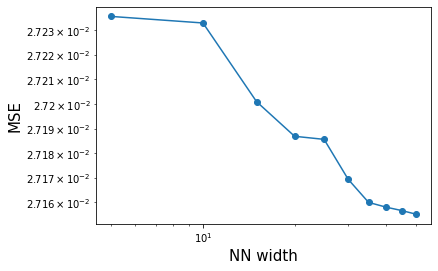

In [15]:
# Next try: relu2 (not just last layer)

plt.plot(ws, losses_w, marker="o")
#plt.plot(ws, losses_w_test, marker="o")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('NN width',fontsize=15)
plt.ylabel('MSE',fontsize=15)